# Imports
CMM: removed redundant & unused imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import io
import re
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from ABRA_35.models import interpolate_and_smooth, CNN

warnings.filterwarnings('ignore')
%matplotlib inline


# Data Processing

In [4]:
filter1 = 128
filter2 = 32
dropout1 = 0.5
dropout2 = 0.3
dropout_fc = 0.1

# Model initialization
peak_finding_model = CNN(filter1, filter2, dropout1, dropout2, dropout_fc)
model_loader = torch.load('./ABRA_35/models/waveI_cnn.pth')
peak_finding_model.load_state_dict(model_loader)
peak_finding_model.eval()

CNN(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1952, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout_fc): Dropout(p=0.1, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [5]:
def peak_finding(wave):
    # Prepare waveform
    waveform=interpolate_and_smooth(wave) # Added indexing per calculate and plot wave function
    # waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0) archived ABRA
    waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0) #newer ABRA
    # print(waveform_torch)
    # Get prediction from model
    outputs = peak_finding_model(waveform_torch)
    prediction = int(round(outputs.detach().numpy()[0][0], 0))
    # prediction_test = int(round(outputs.detach().numpy()[0], 0))
    # print("Model output:", outputs, "Prediction true start:", prediction)

    # Apply Gaussian smoothing
    smoothed_waveform = gaussian_filter1d(waveform, sigma=1)

    # Find peaks and troughs
    n = 18
    t = 14
    # start_point = prediction - 9 archived ABRA
    start_point = prediction - 6 #newer ABRA
    smoothed_peaks, _ = find_peaks(smoothed_waveform[start_point:], distance=n)
    smoothed_troughs, _ = find_peaks(-smoothed_waveform, distance=t)
    sorted_indices = np.argsort(smoothed_waveform[smoothed_peaks+start_point])
    highest_smoothed_peaks = np.sort(smoothed_peaks[sorted_indices[-5:]] + start_point)
    relevant_troughs = np.array([])
    for p in range(len(highest_smoothed_peaks)):
        c = 0
        for t in smoothed_troughs:
            if t > highest_smoothed_peaks[p]:
                if p != 4:
                    try:
                        if t < highest_smoothed_peaks[p+1]:
                            relevant_troughs = np.append(relevant_troughs, int(t))
                            break
                    except IndexError:
                        pass
                else:
                    relevant_troughs = np.append(relevant_troughs, int(t))
                    break
    relevant_troughs = relevant_troughs.astype('i')
    return highest_smoothed_peaks, relevant_troughs

def extract_metadata(metadata_lines):
    # Dictionary to store extracted metadata
    metadata = {}
    
    for line in metadata_lines:
        # Extract SW FREQ
        freq_match = re.search(r'SW FREQ:\s*(\d+\.?\d*)', line)
        if freq_match:
            metadata['SW_FREQ'] = float(freq_match.group(1))
        
        # Extract LEVELS
        levels_match = re.search(r':LEVELS:\s*([^:]+)', line)
        if levels_match:
            # Split levels and convert to list of floats
            metadata['LEVELS'] = [float(level) for level in levels_match.group(1).split(';') if level]
    
    return metadata

def read_custom_tsv(file_path):
    # Read the entire file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        content = f.read()
    
    # Split the content into metadata and data sections
    metadata_lines = []
    data_section = None
    
    # Find the ':DATA' marker
    data_start = content.find(':DATA')
    
    if data_start != -1:
        # Extract metadata (lines before ':DATA')
        metadata_lines = content[:data_start].split('\n')
        
        # Extract data section
        data_section = content[data_start:].split(':DATA')[1].strip()
    
    # Extract specific metadata
    metadata = extract_metadata(metadata_lines)
    
    # Read the data section directly
    try:
        # Use StringIO to create a file-like object from the data section
        raw_data = pd.read_csv(
            io.StringIO(data_section), 
            sep='\s+',  # Use whitespace as separator
            header=None
        )
        raw_data = raw_data.T
        # Add metadata columns to the DataFrame
        if 'SW_FREQ' in metadata:
            raw_data['Freq(kHz)'] = metadata['SW_FREQ']
            # raw_data['Freq(Hz)'] = raw_data['Freq(Hz)'].apply(lambda x: x*1000)
        
        if 'LEVELS' in metadata:
            # Repeat levels to match the number of rows
            levels_repeated = metadata['LEVELS'] * (len(raw_data) // len(metadata['LEVELS']) + 1)
            raw_data['Level(dB)'] = levels_repeated[:len(raw_data)]
        
        filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()
        filtered_data.columns = filtered_data.columns.map(str)

        columns = ['Freq(kHz)'] + ['Level(dB)'] + [col for col in filtered_data.columns if col.isnumeric() == True]
        filtered_data = filtered_data[columns]
        return filtered_data
    
    except Exception as e:
        print(f"Error reading data: {e}")
        return None, metadata

In [7]:
def peaks_troughs_amp_final(df, freq, db, time_scale=10, multiply_y_factor=1.0, units='Microvolts'):
    db_column = 'Level(dB)'
    
    khz = df[(df['Freq(kHz)'] == freq) & (df[db_column] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        # Process the wave as in calculate_and_plot_wave
        y_values = interpolate_and_smooth(final, target)
        
        # Apply scaling factor
        y_values *= multiply_y_factor
        
        # Handle units conversion if needed
        if units == 'Nanovolts':
            y_values /= 1000
            
        # Generate normalized version for peak finding
        y_values_fpf = interpolate_and_smooth(y_values[:244])
        
        # Standardize and normalize for peak finding, exactly as in the original
        flattened_data = y_values_fpf.flatten().reshape(-1, 1)
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(y_values_fpf.shape)
        y_values_fpf = interpolate_and_smooth(scaled_data[:244])
        
        # Find peaks using the normalized data
        highest_peaks, relevant_troughs = peak_finding(y_values_fpf)
        
        # Calculate amplitude on the processed but non-normalized data
        if highest_peaks.size > 0 and relevant_troughs.size > 0:
            # Following the same approach as in the display_metrics_table function
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]
            return highest_peaks, relevant_troughs, first_peak_amplitude
    
    return None, None, None

In [9]:
# del int
time_scale = 18
amp_per_freq = {'Subject': [], 'Freq(kHz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
start_path = '../liberman_wpz/WPZ Electrophysiology'
for subject in os.listdir(start_path):
    if not os.path.isdir(os.path.join(start_path,subject)):
        continue

    # print("Subject:",subject)
    for fq in os.listdir(os.path.join(start_path,subject)):
        # print(fq)
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            path = os.path.join(start_path,subject,fq)
            data_df = read_custom_tsv(path)
            # print(data_df)
            freqs = data_df['Freq(kHz)'].unique().tolist()
            levels = data_df['Level(dB)'].unique().tolist()
            for freq in freqs:
                for lvl in levels:
                    # print("Frequency=",freq, "Level=", lvl)
                    _, _, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
                    # print(f'Amplitude: {amp}\n')
                    amp_per_freq['Subject'].append(subject)
                    amp_per_freq['Freq(kHz) (x1)'].append(freq)
                    amp_per_freq['Level(dB) (x2)'].append(lvl)
                    amp_per_freq['Amplitude (x3)'].append(amp)
        else:
            pass


amp_df_full = pd.DataFrame(data=amp_per_freq)

raw_synapse_counts = pd.read_excel('../liberman_wpz/WPZ Ribbon and Synapse Counts.xlsx')
raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isnull()).dropna()
raw_synapse_counts['Synapses to IHC (y1)'] = raw_synapse_counts.iloc[:,6]
raw_synapse_counts['vx (x4)'] = raw_synapse_counts['vx']
raw_synapse_counts.drop(columns=['vx'], inplace=True)
raw_synapse_counts.rename(columns={'Freq':'Freq(kHz) (x1)'}, inplace=True)
# raw_synapse_counts['Freq(Hz) (x1)'] = raw_synapse_counts['Freq(Hz) (x1)'].apply(lambda x: x*1000) # PUTTING BACK
raw_synapse_counts.rename(columns={'Case':'Subject'}, inplace=True)

In [11]:
# Version 1 - values per vx

paired = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# slice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final = paired[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final_clean = final.dropna()

# adding in the strain feature
strains = pd.read_excel('../liberman_wpz/WPZ Mouse groups.xlsx')
final_clean_strained = final_clean.join(strains.set_index('ID#'), on='Subject')
final_clean_strained['Strain'] = final_clean_strained['Strain'].str.strip()
final_clean_strained = final_clean_strained.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained = final_clean_strained.dropna()
final_clean_strained = final_clean_strained[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group']]

final_clean_strained_grouped = final_clean_strained.copy()
final_clean_strained_grouped['Group - dB'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped['Group - Time Elapsed'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped.head()

final_clean_strained_grouped_pos = final_clean_strained_grouped.copy()
final_clean_strained_grouped_pos['Amplitude (x3)'] = final_clean_strained_grouped['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

final_clean_strained_grouped_pos_cleangroup = final_clean_strained_grouped_pos.copy()
final_clean_strained_grouped_pos_cleangroup['Group'] = final_clean_strained_grouped_pos_cleangroup['Group'].apply(lambda x: x.strip())

final_clean_strained_grouped_pos_cleangroup.head()
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup.copy()
final_clean_strained_grouped_pos_cleangroup_vs['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup_vs[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed = final_clean_strained_grouped_pos_cleangroup_vs.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)

In [13]:
# Version 2 - Averaged per Vx

paired2 = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# lilslice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final2 = paired2[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'Synapses', 'IHCs']]
final_clean2 = final2.dropna()

# adding in the strain feature
#strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained2 = final_clean2.join(strains.set_index('ID#'), on='Subject')
final_clean_strained2['Strain'] = final_clean_strained2['Strain'].str.strip()
final_clean_strained2 = final_clean_strained2.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained2 = final_clean_strained2.dropna()
final_clean_strained2 = final_clean_strained2[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group', 'Synapses', 'IHCs']]
# np.unique(final_clean_strained2['Group'])

# final_clean_70 = final_clean[final_clean['Level(dB) (x2)'] >= 70.0]
# final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB) (x2)'] >= 70.0]
# # np.unique(final_clean['Level(dB) (x2)']) max level is 80 db
# len(final_clean), len(final_clean_70) # 10000 less data points!!!

final_clean_strained_grouped2 = final_clean_strained2.copy()
final_clean_strained_grouped2['Group - dB'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped2['Group - Time Elapsed'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped2.head()

final_clean_strained_grouped_pos2 = final_clean_strained_grouped2.copy()
final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

len(final_clean_strained_grouped_pos2[final_clean_strained_grouped_pos2['Amplitude (x3)'] < 0])

final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

# final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Subject'] == 'WPZ66') & (final_clean_strained_grouped_pos['Amplitude (x3)'] ==0.055901451434921576)
final_clean_strained_grouped_pos_cleangroup2 = final_clean_strained_grouped_pos2.copy()
final_clean_strained_grouped_pos_cleangroup2['Group'] = final_clean_strained_grouped_pos_cleangroup2['Group'].apply(lambda x: x.strip())
np.unique(final_clean_strained_grouped_pos_cleangroup2['Group'])

final_clean_strained_grouped_pos_cleangroup2.head()
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup2.copy()
final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup_vs2[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)', 'Synapses', 'IHCs']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed2 = final_clean_strained_grouped_pos_cleangroup_vs2.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)
final_clean_strained_grouped_pos_cleangroup_vs_timed2

freqs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Freq(kHz) (x1)'])
subs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Subject'])
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx = final_clean_strained_grouped_pos_cleangroup_vs_timed2.copy()
for freq in freqs:
    for sub in subs:
        mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)] # global for updates
        if len(mask) > 0:

            mask1 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v1')]
            mask2 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v2')]

            if not mask1.empty and not mask2.empty:
                mask1 = mask1.reset_index().iloc[0,:]
                mask2 = mask2.reset_index().iloc[0,:]

                total_syns = float(mask1['Synapses'] + mask2['Synapses'])
                total_ihcs = float(mask1['IHCs'] + mask2['IHCs'])
                ratio = total_syns / total_ihcs
                # print(total_syns, total_ihcs)
                # if total_syns == 0.0 or total_ihcs == 0.0:
                #     print(sub, freq)
                mask_index = mask.index
                final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[mask_index,'Synapse to IHC Ratio per Freq (y2)'] = ratio

final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Synapse to IHC Ratio per Freq (y2)']

0        9.831461
0        9.831461
1        9.831461
1        9.831461
2        9.831461
          ...    
7328    16.170213
7329    16.170213
7329    16.170213
7330    16.170213
7330    16.170213
Name: Synapse to IHC Ratio per Freq (y2), Length: 12187, dtype: float64

# Bayesian Model Comparison

## Model

In [14]:
class BayesianProfile_LRcompare:
    def __init__(self, training_data=None, prior_mean_y1=None, prior_cov_y1=None):
        """
        Initialize a Bayesian profile with static scaling
        
        Parameters:
        training_data: DataFrame with initial data to fit scalers
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 48 parameters: intercept, x1, x3, interaction
        self.n_params = 4
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean_y1 = prior_mean_y1
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        
        # Initialize scalers
        self.x1_scaler = StandardScaler()
        self.x3_scaler = StandardScaler()
        
        # Initialize scaling flag
        self.scaling_applied = False
        
        # Fit scalers if training data is provided
        if training_data is not None:
            self._initialize_scalers(training_data)

    def _initialize_scalers(self, data):
        """
        Initialize scalers with training data
        """
        if 'Freq(kHz) (x1)' in data.columns and 'Amplitude (x3)' in data.columns:
            # Fit scalers to all training data once
            self.x1_scaler.fit(data['Freq(kHz) (x1)'].values.reshape(-1,1))
            self.x3_scaler.fit(data['Amplitude (x3)'].values.reshape(-1, 1))
            self.scaling_applied = True
            print(f"Scalers initialized with {len(data)} records")
        else:
            print("Warning: Training data missing required columns for scaling")

    def _scale_x1(self, x1):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x1  # Return as is if scaler not fit
        
        x1_array = np.array([float(x1)]).reshape(-1, 1)
        return self.x1_scaler.transform(x1_array)[0][0]

    def _scale_x3(self, x3):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x3
        
        x3_array = np.array([float(x3)]).reshape(-1, 1)
        return self.x3_scaler.transform(x3_array)[0][0]
        
    def add_observation_y1(self, x1, x3, y1, noise_var=1.0, prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation using static scaling
        """
        self.raw_x1 = float(x1)
        self.raw_x3 = float(x3)
        self.raw_y1 = float(y1)
        
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape for processing
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            (x1_scaled.T @ x3_scaled).reshape(1,-1)                                  
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(float(y1))
        
        # Numerical stability in matrix inversion
        try:
            # regularization for numerical stability
            K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var + 1e-8 * np.eye(X.shape[0]))
            
            innovation = y1 - float(X @ self.mean_y1)
            self.mean_y1 = self.mean_y1 + (K.flatten() * innovation) # our coefficients/parameters!
            self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1) # prep for the Kalman gain in our next set of observations
        except np.linalg.LinAlgError as e:
            print(f"Matrix inversion error: {e}")
            return
        
        try:
            predictions = []
            for i, x_hist in enumerate(self.X_history):
                # Extract features from history
                hist_x1 = x_hist[1]
                hist_x3 = x_hist[2]
                    
                try:
                    # print(f"self.mean_y1: {self.mean_y1}, self.cov_y1 shape: {self.cov_y1.shape}")
                    # print(f"Trying to predict with x1={hist_x1}, x3={hist_x3}")
                    pred = self.predict_y1(x1=hist_x1, x3=hist_x3)
                    # print(pred)
                    if pred is not None and np.isfinite(pred):
                        predictions.append(pred)
                except Exception as e:
                    print(f"Error in prediction: {e}.")
                    
            if predictions:
                rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2)) # predictions likely source of errorrrrrr
                print(rmse)
                if np.isfinite(rmse):
                    print(rmse)
                    self.rmse_history_y1.append(rmse)
                else:
                    # If we got an invalid RMSE, append the last valid one or 0
                    if self.rmse_history_y1:
                        self.rmse_history_y1.append(self.rmse_history_y1[-1])
                        print("Invalid RMSE!! Check here")
                    else:
                        self.rmse_history_y1.append(0.0)
        except Exception as e:
            print(f"Error !calculating! RMSE: {e}")
            # Append last RMSE or 0 if none exists
            if self.rmse_history_y1:
                self.rmse_history_y1.append(self.rmse_history_y1[-1])
            else:
                self.rmse_history_y1.append(0.0)

    def predict_y1(self, x1,x3):
        """
        Make a prediction for given input values with static scaling
        
        Parameters:
        x1, x3: Input features (will be scaled if scaling is enabled)
        x5: Categorical feature
        x6, x7: Additional input features
        
        Returns:
        float: Predicted value (in original scale)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            np.array(x1_scaled * x3_scaled).reshape(1, -1)                                  
        ]

        X = np.hstack(arrays_to_stack)

        raw_pred = float(X @ self.mean_y1) # mean_y1 likely error source
        if not np.isfinite(raw_pred):
            print(f"Non-finite prediction for x1={x1_scaled},x3={x3_scaled}")
            # print(f"Model coefficients: {self.mean_y1}")
        pred = max(0, raw_pred)
        return pred

    def predict_with_uncertainty_y1(self, x1, x3):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            np.array(x1_scaled * x3_scaled).reshape(1, -1)                            
        ]
        
        X = np.hstack(arrays_to_stack)
        
        # Predict
        pred = float(X @ self.mean_y1)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))
        # pred_scaled = float(X @ self.mean_y1)
        # std_scaled = float(np.sqrt(X @ self.cov_y1 @ X.T))

        # if self.scaling_applied:
        #     std = std_scaled * self.y1_scaler.scale_[0]
        # else:
        #     std = std_scaled
        
        # Check for valid values
        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        
        # Transform back to original scale
        # pred = self._inverse_scale_y1(pred_scaled)

        pred = float(X @ self.mean_y1)
        pred = max(0, pred)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))

        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        # Convert back to original scale if scaling was applied
        return pred, std

## CV - Grouped by Subject, Randomly test frequency, original target

In [15]:
# Split data based on ABR recording frequencies and compare!!!!!!!
# Because it doesn't make sense to have TT by subject for this given one model is specific to a subject...
np.random.seed(12321)
groups = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'])
sorted_freqs = sorted(np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)']))

freq_groups = {}
for i, freq in enumerate(sorted_freqs):
    # Splits up the frequencies into n groups
    group_idx = i % 3
    if group_idx not in freq_groups:
        freq_groups[group_idx] = []
    freq_groups[group_idx].append(freq)

print(freq_groups)

records_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'].unique():
    records_in_group = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'] == group]
    records_by_group[group] = records_in_group

train_freqs = []
test_freqs = []

for group_idx, freqs in freq_groups.items():
    # Shuffle frequencies within this group (kinda like RF. randomly splits on which freqs to use in train/test)
    np.random.shuffle(freqs)
    
    n_test = max(1, round(len(freqs) * 0.2))  # Ensuring at least 2 frequencies are used for testing

    # Add to overall train/test sets
    test_freqs.extend(freqs[:n_test])
    train_freqs.extend(freqs[n_test:])

# train_indices = []
# test_indices = []

# for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group']):
#     group_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'] == group]
#     train_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(train_freqs)].index.tolist()
#     test_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(test_freqs)].index.tolist()

    # test_indices.extend(test_group_indices)
    # train_indices.extend(train_group_indices)

train_indices = set()
test_indices = set()

for subject in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject']):
    subject_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == subject]

    train_subject_indices = subject_recs[subject_recs['Freq(kHz) (x1)'].isin(train_freqs)].index.tolist()
    test_subject_indices = subject_recs[subject_recs['Freq(kHz) (x1)'].isin(test_freqs)].index.tolist()

    # Ensure the subject has data in both splits
    if len(train_subject_indices) == 0 or len(test_subject_indices) == 0:
        continue  # Skip this subject to avoid leakage problems

    test_indices.update(test_subject_indices)
    train_indices.update(train_subject_indices)


x_inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group']
y_inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Synapses to IHC (y1)', 'Synapse to IHC Ratio per Freq (y2)']
X_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(train_indices), x_inputs].reset_index(drop=True)
X_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(test_indices), x_inputs].reset_index(drop=True)

y1_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(train_indices), y_inputs].reset_index(drop=True)
y1_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(test_indices), y_inputs].reset_index(drop=True)

y2_train10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(train_indices), y_inputs].reset_index(drop=True)
y2_test10 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(test_indices), y_inputs].reset_index(drop=True)

y1_inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group', 'Synapses to IHC (y1)']
y2_inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group', 'Synapse to IHC Ratio per Freq (y2)']

predict_per_vx_train = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(train_indices), y1_inputs].reset_index(drop=True)
predict_per_freq_train = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(train_indices), y2_inputs].reset_index(drop=True)

{0: [np.float64(8.0), np.float64(22.6)], 1: [np.float64(11.3), np.float64(32.0)], 2: [np.float64(16.0), np.float64(45.2)]}


In [16]:
y1_train10.head()

,Subject,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),Synapses to IHC (y1),Synapse to IHC Ratio per Freq (y2)
0,WPZ145,22.6,30.0,0.046317,11.320755,11.534653
1,WPZ145,22.6,30.0,0.046317,11.770833,11.534653
2,WPZ145,22.6,35.0,0.115609,11.320755,11.534653
3,WPZ145,22.6,35.0,0.115609,11.770833,11.534653
4,WPZ145,22.6,40.0,0.323602,11.320755,11.534653


In [17]:
predict_per_freq_train[(predict_per_freq_train['Subject'] == 'WPZ145')\
            & (predict_per_freq_train['Freq(kHz) (x1)'] == 22.6)]

# type(y2_train10['Freq(kHz) (x1)'].iloc[0])

,Subject,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group,Synapse to IHC Ratio per Freq (y2)
0,WPZ145,22.6,30.0,0.046317,v1,C57B6,98dB 8wks post,11.534653
1,WPZ145,22.6,30.0,0.046317,v2,C57B6,98dB 8wks post,11.534653
2,WPZ145,22.6,35.0,0.115609,v1,C57B6,98dB 8wks post,11.534653
3,WPZ145,22.6,35.0,0.115609,v2,C57B6,98dB 8wks post,11.534653
4,WPZ145,22.6,40.0,0.323602,v1,C57B6,98dB 8wks post,11.534653
5,WPZ145,22.6,40.0,0.323602,v2,C57B6,98dB 8wks post,11.534653
6,WPZ145,22.6,50.0,0.523731,v1,C57B6,98dB 8wks post,11.534653
7,WPZ145,22.6,50.0,0.523731,v2,C57B6,98dB 8wks post,11.534653
8,WPZ145,22.6,60.0,0.637744,v1,C57B6,98dB 8wks post,11.534653
9,WPZ145,22.6,60.0,0.637744,v2,C57B6,98dB 8wks post,11.534653


In [41]:
# y1_train10[(y1_train10['Subject'] == 'WPZ100') & (y1_train10['Freq(kHz) (x1)'] == 16.0)]

In [18]:
# fixed to have subjects stay within one fold

thresh = 0
train_rmse_scores = []
val_rmse_scores = []
subjects_profiles_CVsplit_LR = {}
all_train_data = {}
all_val_data = {}

groups = [str(group) for group in np.unique(X_train10['Group'])]
group_train_rmse = {group: [] for group in groups}
group_val_rmse = {group: [] for group in groups}

subject_group_df = X_train10.groupby('Subject').first().reset_index()
subject_labels = subject_group_df['Group'].values
subject_ids = subject_group_df['Subject'].values

group_k_fold = GroupKFold(n_splits=5, shuffle=True, random_state=42)
for fold_idx, (train_idx, val_idx) in enumerate(group_k_fold.split(X_train10, groups=X_train10['Subject'])):
    X_fold_train, X_fold_val = X_train10.iloc[train_idx], X_train10.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train10.iloc[train_idx], y1_train10.iloc[val_idx]
    print(f"\nProcessing Fold {fold_idx+1}")

    for subject in np.unique(X_fold_train['Subject']):
        subjects_profiles_CVsplit_LR[subject] = BayesianProfile_LRcompare()

        subject_data = X_fold_train[X_fold_train['Subject'] == subject]

        grouped = subject_data.groupby([
            'Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)',   
            'Group'
        ])

        for group_key, group_data in grouped:
            if group_data['Level(dB) (x2)'].min() < thresh:
                continue

            for idx, row in group_data.iterrows():
                x1_val = row['Freq(kHz) (x1)']
                x3_val = row['Amplitude (x3)']
                y1_val = y_fold_train.loc[idx]['Synapses to IHC (y1)']

                # print(type(x1_val))
                # print(type(x3_val))
                # print(y1_val)

                subjects_profiles_CVsplit_LR[subject].add_observation_y1(
                    x1=x1_val,
                    x3=x3_val,
                    y1=float(y1_val)
                )

    train_predictions = {}

    for idx, row in X_fold_train.iterrows():
        if row['Level(dB) (x2)'] >= thresh:
            subject = row['Subject']
            x1_train = row['Freq(kHz) (x1)']
            x3_train = row['Amplitude (x3)']
        if subject in subjects_profiles_CVsplit_LR:
            pred = subjects_profiles_CVsplit_LR[subject].predict_y1(x1= x1_train, x3=x3_train)
            train_predictions[idx] = float(pred) 

    successful_train_indices = list(train_predictions.keys())

    if successful_train_indices:
        y_train_true = y_fold_train.loc[successful_train_indices]
        y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
                                index=successful_train_indices)

    val_predictions = {}

    for idx, row in X_fold_val.iterrows():
        if row['Level(dB) (x2)'] >= thresh:
            subject = row['Subject']
            x1_val = row['Freq(kHz) (x1)']
            x3_val = row['Amplitude (x3)']
        if subject in subjects_profiles_CVsplit_LR:
            pred = subjects_profiles_CVsplit_LR[subject].predict_y1(x1= x1_val, x3=x3_val)
            val_predictions[idx] = float(pred)

    successful_val_indices = list(val_predictions.keys())

    if successful_val_indices:
        y_val_true = y_fold_val.loc[successful_val_indices]
        y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
                            index=successful_val_indices)

        # Print basic information
        print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
        print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")

        # Calculate train RMSE
        true_name = f'{fold_idx} - train - true'
        pred_name = f'{fold_idx} - train - pred'
        all_train_data[true_name] = y_train_true
        all_train_data[pred_name] = y_train_pred

        fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
        train_rmse_scores.append(fold_train_rmse)

        # Calculate val RMSE
        true_name = f'{fold_idx} - val - true'
        pred_name = f'{fold_idx} - val - pred'
        all_val_data[true_name] = y_val_true
        all_val_data[pred_name] = y_val_pred

        fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
        val_rmse_scores.append(fold_val_rmse)

        # Calculate group-specific RMSE
        for group in groups:
            # Get the subject groups
            # train_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[successful_train_indices]
            # val_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_val_indices]
            train_subjects_df = X_train10.loc[successful_train_indices]
            val_subjects_df = X_train10.loc[successful_val_indices]

            # Filter for successful predictions for this group
            group_train_mask = train_subjects_df['Group'] == group
            if group_train_mask.any():
                group_indices = group_train_mask.index[group_train_mask]
                group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
                group_train_rmse[group].append(group_rmse)

            group_val_mask = val_subjects_df['Group'] == group
            if group_val_mask.any():
                group_indices = group_val_mask.index[group_val_mask]
                group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
                group_val_rmse[group].append(group_rmse)

        print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
    else:
        print(f"Fold {fold_idx+1}: No successful training predictions")

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    std_val_rmse = np.std(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")



Processing Fold 1
0.0016459232157330916
0.0016459232157330916
0.7295801236834172
0.7295801236834172
0.6248879256709063
0.6248879256709063
0.7295837356413585
0.7295837356413585
0.6545675353849547
0.6545675353849547
0.7295800468804032
0.7295800468804032
0.6827551882746679
0.6827551882746679
0.7295797813421218
0.7295797813421218
0.7064234406911316
0.7064234406911316
0.7295797474507704
0.7295797474507704
0.7089477770387465
0.7089477770387465
0.7295797269959997
0.7295797269959997
0.7161579170391874
0.7161579170391874
0.72957971857291
0.72957971857291
0.7193043510911175
0.7193043510911175
0.7295797134706469
0.7295797134706469
0.7231691273237268
0.7231691273237268
0.7295797107274852
0.7295797107274852
0.7253733458088619
0.7253733458088619
0.7295797089668007
0.7295797089668007
0.006496809362218414
0.006496809362218414
0.3741337446917596
0.3741337446917596
0.3056605755071715
0.3056605755071715
0.37412669674603577
0.37412669674603577
0.36097191322459715
0.36097191322459715
0.3741245519904899
0.

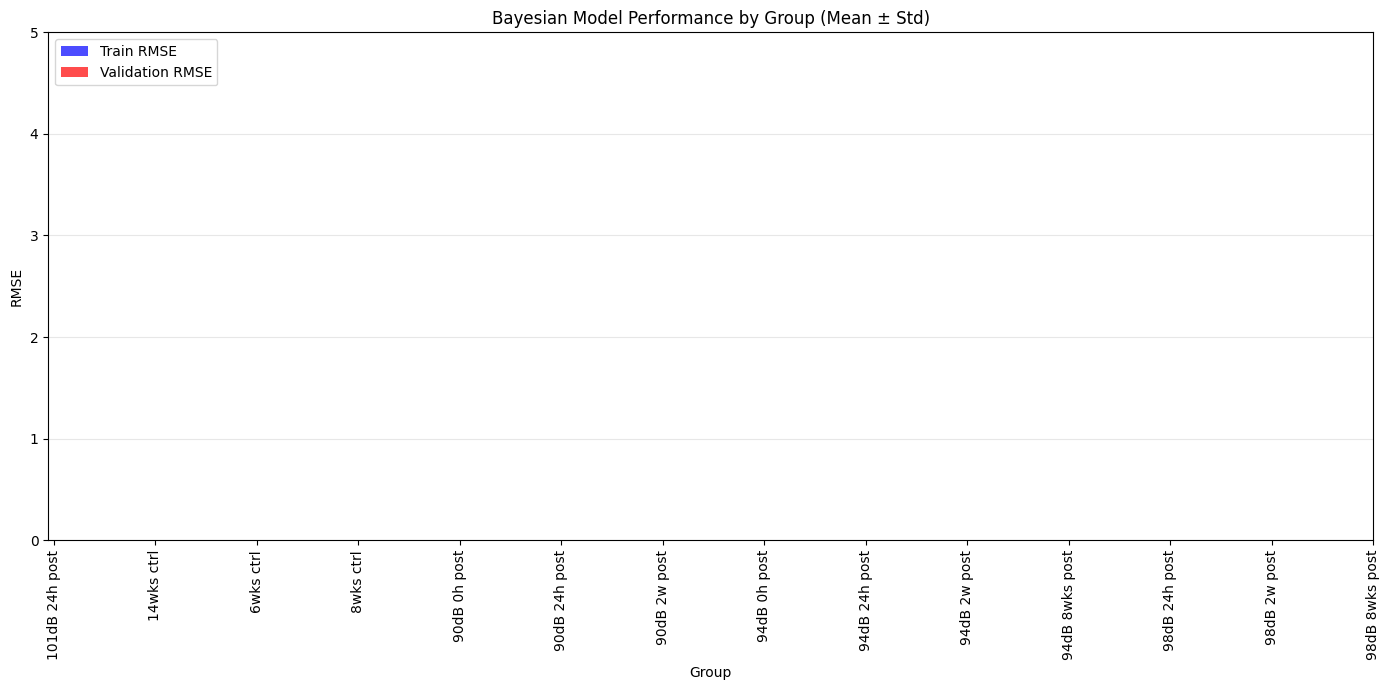

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std
0,101dB 24h post,NaN,NaN,NaN,NaN
1,14wks ctrl,NaN,NaN,NaN,NaN
2,6wks ctrl,NaN,NaN,NaN,NaN
3,8wks ctrl,NaN,NaN,NaN,NaN
4,90dB 0h post,NaN,NaN,NaN,NaN
5,90dB 24h post,NaN,NaN,NaN,NaN
6,90dB 2w post,NaN,NaN,NaN,NaN
7,94dB 0h post,NaN,NaN,NaN,NaN
8,94dB 24h post,NaN,NaN,NaN,NaN
9,94dB 2w post,NaN,NaN,NaN,NaN


In [19]:
# Visualization of group-specific RMSE
if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    plot_train_std = []
    plot_val_std = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
            plot_train_std.append(np.std(group_train_rmse[group]))
            plot_val_std.append(np.std(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
                label='Train RMSE', color='blue', alpha=0.7, capsize=5)
        plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
                label='Validation RMSE', color='red', alpha=0.7, capsize=5)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.ylim((0,5))
        plt.title('Bayesian Model Performance by Group (Mean ± Std)')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

group_metrics_df

In [20]:
len(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx)

12187

In [21]:
db98data = pd.DataFrame(group_metrics_df.iloc[-1,:]).T
group_metrics_df_copy = group_metrics_df.copy()
group_metrics_df_copy.iloc[-1,:] = group_metrics_df_copy.iloc[0,:]
group_metrics_df_copy = group_metrics_df_copy[1:]
# group_metrics_df_copy.iloc[0,:] = group_metrics_df_copy.iloc[1,:]
r14 = group_metrics_df_copy.iloc[0,:]
r6 = group_metrics_df_copy.iloc[1,:]
r8 = group_metrics_df_copy.iloc[2,:]
group_metrics_df_copy.iloc[0,:] = r6
group_metrics_df_copy.iloc[1,:] = r8
group_metrics_df_copy.iloc[2,:] = r14
# group_metrics_df_copy['Group'] = group_metrics_df_copy['Group'].apply(lambda x: f"'{x}'")
db101 = pd.DataFrame(group_metrics_df_copy.iloc[-1,:]).T
group_metrics_df_copy.drop(group_metrics_df_copy.tail(1).index,inplace=True)
# group_metrics_df_copy = pd.concat([group_metrics_df_copy, db98data], axis=0)
# group_metrics_df_copy = pd.concat([group_metrics_df_copy, db101], axis=0)
group_metrics_df_copy_final = pd.concat([group_metrics_df_copy, db98data, db101], ignore_index=True)

group_metrics_df_copy_final

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std
0,6wks ctrl,NaN,NaN,NaN,NaN
1,8wks ctrl,NaN,NaN,NaN,NaN
2,14wks ctrl,NaN,NaN,NaN,NaN
3,90dB 0h post,NaN,NaN,NaN,NaN
4,90dB 24h post,NaN,NaN,NaN,NaN
5,90dB 2w post,NaN,NaN,NaN,NaN
6,94dB 0h post,NaN,NaN,NaN,NaN
7,94dB 24h post,NaN,NaN,NaN,NaN
8,94dB 2w post,NaN,NaN,NaN,NaN
9,94dB 8wks post,NaN,NaN,NaN,NaN


## CV - Predicting for total ratio across viewing fields

In [45]:
# Split data based on ABR recording frequencies and compare!!!!!!!
# Because it doesn't make sense to have TT by subject for this given one model is specific to a subject...
np.random.seed(12321)
groups = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'])
sorted_freqs = sorted(np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)']))

freq_groups = {}
for i, freq in enumerate(sorted_freqs):
    # Splits up the frequencies into n groups
    group_idx = i % 3
    if group_idx not in freq_groups:
        freq_groups[group_idx] = []
    freq_groups[group_idx].append(freq)

print(freq_groups)

records_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'].unique():
    records_in_group = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Group'] == group]
    records_by_group[group] = records_in_group

train_freqs = []
test_freqs = []

for group_idx, freqs in freq_groups.items():
    # Shuffle frequencies within this group (kinda like RF. randomly splits on which freqs to use in train/test)
    np.random.shuffle(freqs)
    
    n_test = max(1, round(len(freqs) * 0.2))  # Ensuring at least 2 frequencies are used for testing

    # Add to overall train/test sets
    test_freqs.extend(freqs[:n_test])
    train_freqs.extend(freqs[n_test:])

train_indices = set()
test_indices = set()

for subject in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject']):
    subject_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == subject]

    train_subject_indices = subject_recs[subject_recs['Freq(kHz) (x1)'].isin(train_freqs)].index.tolist()
    test_subject_indices = subject_recs[subject_recs['Freq(kHz) (x1)'].isin(test_freqs)].index.tolist()

    # Ensure the subject has data in both splits
    if len(train_subject_indices) == 0 or len(test_subject_indices) == 0:
        continue  # Skip this subject to avoid leakage problems

    test_indices.update(test_subject_indices)
    train_indices.update(train_subject_indices)

y1_inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)', 'Group', 'Synapses to IHC (y1)']
y2_inputs = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)', 'Group', 'Synapse to IHC Ratio per Freq (y2)']

predict_per_vx_train = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(train_indices), y1_inputs].reset_index(drop=True)
predict_per_freq_train = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[list(train_indices), y2_inputs].reset_index(drop=True)

predict_per_freq_train_slim = predict_per_freq_train.groupby(['Subject', 'Freq(kHz) (x1)']).first().reset_index()
predict_per_freq_train_slim

{0: [np.float64(8.0), np.float64(22.6)], 1: [np.float64(11.3), np.float64(32.0)], 2: [np.float64(16.0), np.float64(45.2)]}


,Subject,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),Strain (x5),Group,Synapse to IHC Ratio per Freq (y2)
0,WPZ100,16.0,10.0,0.077363,C57B6,8wks ctrl,17.487437
1,WPZ100,22.6,15.0,0.085015,C57B6,8wks ctrl,17.378641
2,WPZ100,32.0,15.0,0.173144,C57B6,8wks ctrl,18.282828
3,WPZ101,32.0,10.0,0.128507,C57B6,8wks ctrl,16.170213
4,WPZ102,16.0,10.0,0.091656,C57B6,94dB 2w post,16.333333
...,...,...,...,...,...,...,...
306,WPZ98,22.6,10.0,0.056974,C57B6,90dB 2w post,18.535354
307,WPZ98,32.0,10.0,0.017715,C57B6,90dB 2w post,17.500000
308,WPZ99,16.0,10.0,0.012406,C57B6,8wks ctrl,17.947368
309,WPZ99,22.6,10.0,0.079862,C57B6,8wks ctrl,17.524272


In [46]:
# fixed to have subjects stay within one fold

thresh = 0
train_rmse_scores = []
val_rmse_scores = []
subjects_profiles_CVsplit_LR = {}
all_train_data = {}
all_val_data = {}

groups = [str(group) for group in np.unique(predict_per_freq_train['Group'])]
group_train_rmse = {group: [] for group in groups}
group_val_rmse = {group: [] for group in groups}

subject_group_df = predict_per_freq_train.groupby('Subject').first().reset_index()
subject_labels = subject_group_df['Group'].values
subject_ids = subject_group_df['Subject'].values

group_k_fold = GroupKFold(n_splits=5, shuffle=True, random_state=42)
X_cols = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)', 'Group']
y2_cols = ['Synapse to IHC Ratio per Freq (y2)']

X_train = predict_per_freq_train[X_cols]
y2_train = predict_per_freq_train[y2_cols]
for fold_idx, (train_idx, val_idx) in enumerate(group_k_fold.split(X_train, groups=X_train['Subject'])):
    
    X_fold_train, X_fold_val = predict_per_freq_train.loc[train_idx, X_cols], predict_per_freq_train.loc[val_idx, X_cols]
    y_fold_train, y_fold_val = predict_per_freq_train.loc[train_idx, y2_cols], predict_per_freq_train.loc[val_idx, y2_cols]
    print(f"\nProcessing Fold {fold_idx+1}")

    for subject in np.unique(X_fold_train['Subject']):
        for freq in np.unique(X_fold_train['Freq(kHz) (x1)']):
            subjects_profiles_CVsplit_LR[subject] = BayesianProfile_LRcompare()
            subject_freq_data = X_fold_train[(X_fold_train['Subject'] == subject) & (X_fold_train['Freq(kHz) (x1)'] == freq) & (X_fold_train['Level(dB) (x2)'] >= thresh)]

            for amp in np.unique(X_fold_train['Amplitude (x3)']):
                y1_val_index = subject_freq_data[subject_freq_data['Amplitude (x3)'] == amp].index
                y1_val = y_fold_train.loc[y1_val_index, 'Synapse to IHC Ratio per Freq (y2)'].values
                print(y1_val)
                subjects_profiles_CVsplit_LR[subject].add_observation_y1(
                    x1=freq,
                    x3=amp,
                    y1=float(y1_val)
                )

    train_predictions = {}

    for idx, row in X_fold_train.iterrows():
        if row['Level(dB) (x2)'] >= thresh:
            subject = row['Subject']
            x1_train = row['Freq(kHz) (x1)']
            x3_train = row['Amplitude (x3)']
        if subject in subjects_profiles_CVsplit_LR:
            pred = subjects_profiles_CVsplit_LR[subject].predict_y1(x1= x1_train, x3=x3_train)
            train_predictions[idx] = float(pred) 

    successful_train_indices = list(train_predictions.keys())

    if successful_train_indices:
        y_train_true = y_fold_train.loc[successful_train_indices]
        y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
                                index=successful_train_indices)

    val_predictions = {}

    for idx, row in X_fold_val.iterrows():
        if row['Level(dB) (x2)'] >= thresh:
            subject = row['Subject']
            x1_val = row['Freq(kHz) (x1)']
            x3_val = row['Amplitude (x3)']
        if subject in subjects_profiles_CVsplit_LR:
            pred = subjects_profiles_CVsplit_LR[subject].predict_y1(x1= x1_val, x3=x3_val)
            val_predictions[idx] = float(pred)

    successful_val_indices = list(val_predictions.keys())

    if successful_val_indices:
        y_val_true = y_fold_val.loc[successful_val_indices]
        y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
                            index=successful_val_indices)

        # Print basic information
        print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
        print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")

        # Calculate train RMSE
        true_name = f'{fold_idx} - train - true'
        pred_name = f'{fold_idx} - train - pred'
        all_train_data[true_name] = y_train_true
        all_train_data[pred_name] = y_train_pred

        fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
        train_rmse_scores.append(fold_train_rmse)

        # Calculate val RMSE
        true_name = f'{fold_idx} - val - true'
        pred_name = f'{fold_idx} - val - pred'
        all_val_data[true_name] = y_val_true
        all_val_data[pred_name] = y_val_pred

        fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
        val_rmse_scores.append(fold_val_rmse)

        # Calculate group-specific RMSE
        for group in groups:
            # Get the subject groups
            # train_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[successful_train_indices]
            # val_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_val_indices]
            train_subjects_df = predict_per_freq_train_slim.loc[successful_train_indices]
            val_subjects_df = predict_per_freq_train_slim.loc[successful_val_indices]

            # Filter for successful predictions for this group
            group_train_mask = train_subjects_df['Group'] == group
            if group_train_mask.any():
                group_indices = group_train_mask.index[group_train_mask]
                group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
                group_train_rmse[group].append(group_rmse)

            group_val_mask = val_subjects_df['Group'] == group
            if group_val_mask.any():
                group_indices = group_val_mask.index[group_val_mask]
                group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
                group_val_rmse[group].append(group_rmse)

        print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
    else:
        print(f"Fold {fold_idx+1}: No successful training predictions")

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    std_val_rmse = np.std(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

# Visualization of group-specific RMSE
if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    plot_train_std = []
    plot_val_std = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
            plot_train_std.append(np.std(group_train_rmse[group]))
            plot_val_std.append(np.std(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
                label='Train RMSE', color='blue', alpha=0.7, capsize=5)
        plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
                label='Validation RMSE', color='red', alpha=0.7, capsize=5)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.ylim((0,5))
        plt.title('Bayesian Model Performance by Group (Mean ± Std)')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

group_metrics_df


Processing Fold 1
[]


TypeError: only length-1 arrays can be converted to Python scalars